Processando evento 0 de 10000...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Processando evento 1000 de 10000...
Pr

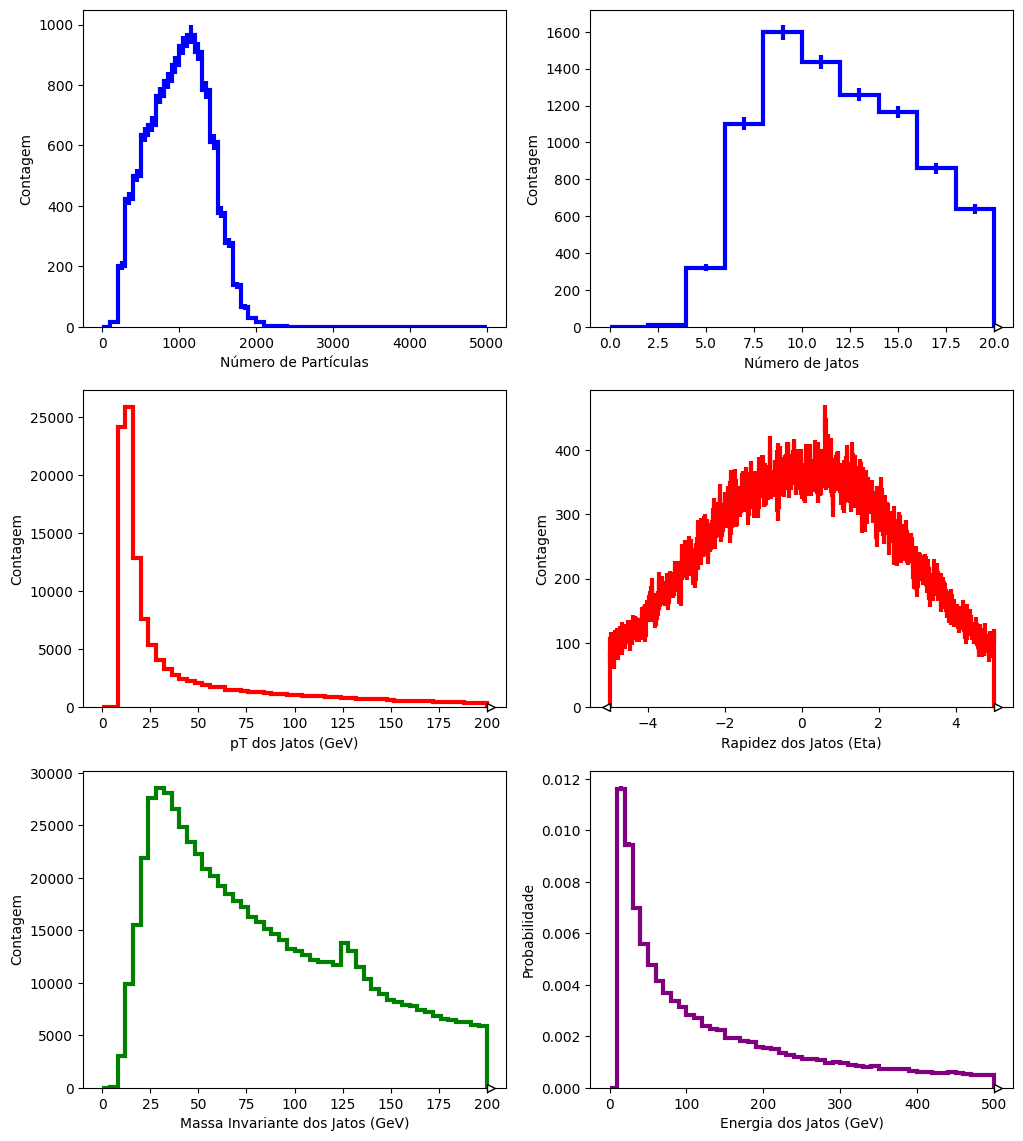

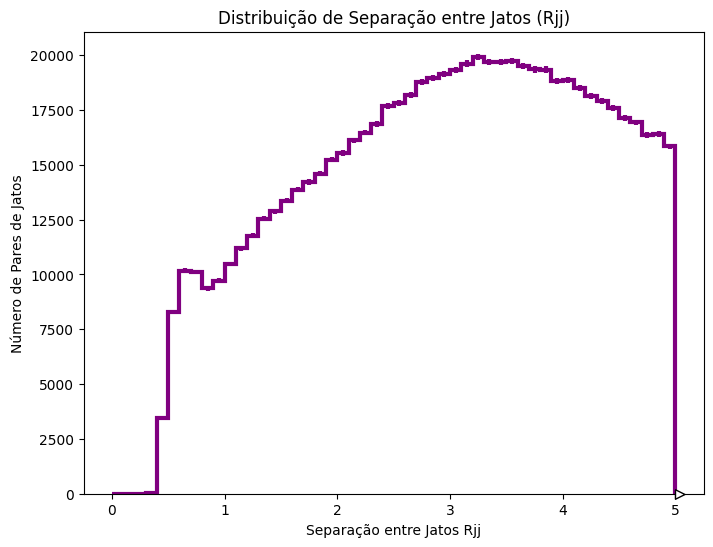

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj

# Caminho para o arquivo .hepmc
hepmc_file = '/home/lphelipe/Resultados/Jets_2b2mu.hepmc'

# Definir histogramas
histo_njets  = hist.Hist.new.Reg(10, 0., 20.).Double()
histo_jets_pt  = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_jets_eta = hist.Hist.new.Reg(500, -5., +5.).Double()
histo_jets_mass = hist.Hist.new.Reg(50, 0., 200.).Double()  # Massa invariante dos jatos
histo_npart  = hist.Hist.new.Reg(50, 0., 5000.).Double()
histo_jets_energy = hist.Hist.new.Reg(50, 0., 500.).Double()  # Energia dos jatos
histo_rjj = hist.Hist.new.Reg(50, 0., 5.0).Double()  # Separação entre jatos (Rjj)

# Função para ler o arquivo HEPMC e extrair os eventos
def read_hepmc_file(hepmc_file):
    events = []
    with hep.open(hepmc_file) as f:
        for event in f:
            events.append(event)  # Adiciona o evento ao arquivo
    return events

# Função para calcular o momento transversal (pT)
def get_pt(particle):
    return np.sqrt(particle.momentum.x**2 + particle.momentum.y**2)

# Função para calcular a pseudorapidez (eta)
def get_eta(particle):
    p = np.sqrt(particle.momentum.x**2 + particle.momentum.y**2 + particle.momentum.z**2)
    if p == 0 or np.isclose(particle.momentum.z, p) or np.isclose(particle.momentum.z, -p):
        return np.nan  # Retorna NaN se não puder calcular
    return 0.5 * np.log((p + particle.momentum.z) / (p - particle.momentum.z))

# Função para calcular a energia de uma partícula
def get_energy(particle):
    return particle.momentum.e

# Função para calcular a separação Rjj entre dois jatos
def delta_r(jet1, jet2):
    delta_eta = jet1.eta() - jet2.eta()
    delta_phi = jet1.phi() - jet2.phi()
    return np.sqrt(delta_eta**2 + delta_phi**2)

# Função para calcular a massa invariante de dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para analisar o evento e preencher os histogramas de jatos
def analyze_event(event):
    # Filtrar partículas com pT > 10 GeV para reconstruir jatos
    particles = [p for p in event.particles if p.status == 1]  # Somente partículas finais (status 1)
    
    # Converter partículas para objetos PseudoJet do FastJet
    fj_particles = []
    for p in particles:
        fj_particle = fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e)
        fj_particles.append(fj_particle)

    # Escolher o algoritmo de clustering (anti-kT, por exemplo)
    jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)  # Radius de 0.4 
    
    # Clustering dos jatos
    clusterer = fj.ClusterSequence(fj_particles, jet_def)
    jets = clusterer.inclusive_jets(10.0)  # Jatos com pT > 10 GeV 
    # Preencher histogramas de jatos
    njets = len(jets)
    histo_njets.fill(njets)
    
    # Preencher histogramas de pT, eta, energia e massa dos jatos
    for jet in jets:
        histo_jets_pt.fill(jet.pt())  # Preencher o histograma de pT dos jatos
        histo_jets_eta.fill(jet.eta())  # Preencher o histograma de eta dos jatos
        histo_jets_energy.fill(jet.e())  # Preencher o histograma de energia dos jatos
        
    # Preencher histograma de massa invariante dos jatos
    if len(jets) >= 2:
        for i in range(len(jets)-1):
            for j in range(i+1, len(jets)):
                mass = invariant_mass(jets[i], jets[j])
                histo_jets_mass.fill(mass)

                # Preencher histograma de separação Rjj entre os jatos
                rjj = delta_r(jets[i], jets[j])
                histo_rjj.fill(rjj)

    # Número de partículas no evento
    npart = len(particles)
    histo_npart.fill(npart)

# Função para visualizar os histogramas
def plot_histograms():
    fig, ax = plt.subplots(3, 2, figsize=(12, 14))

    histo_npart.plot(ax=ax[0, 0], ls="-", color="blue", lw=3)
    ax[0, 0].set(xlabel='Número de Partículas', ylabel='Contagem')

    histo_njets.plot(ax=ax[0, 1], ls="-", color="blue", lw=3)
    ax[0, 1].set(xlabel='Número de Jatos', ylabel='Contagem')

    histo_jets_pt.plot(ax=ax[1, 0], ls="-", color="red", lw=3)
    ax[1, 0].set(xlabel='pT dos Jatos (GeV)', ylabel='Contagem')

    histo_jets_eta.plot(ax=ax[1, 1], ls="-", color="red", lw=3)
    ax[1, 1].set(xlabel='Rapidez dos Jatos (Eta)', ylabel='Contagem')

    histo_jets_mass.plot(ax=ax[2, 0], ls="-", color="green", lw=3)
    ax[2, 0].set(xlabel='Massa Invariante dos Jatos (GeV)', ylabel='Contagem')

    # Plot para a Distribuição de Energia dos Jatos no eixo [2,1]
    histo_jets_energy.plot(ax=ax[2, 1], ls="-", color="purple", lw=3, density=True)
    ax[2, 1].set(xlabel='Energia dos Jatos (GeV)', ylabel='Probabilidade')

    # Histograma de separação Rjj entre jatos
    plt.figure(figsize=(8, 6))
    histo_rjj.plot(ls="-", color="purple", lw=3)
    plt.xlabel('Separação entre Jatos Rjj')
    plt.ylabel('Número de Pares de Jatos')
    plt.title('Distribuição de Separação entre Jatos (Rjj)')
    plt.show()

# Ler eventos do arquivo HEPMC
events = read_hepmc_file(hepmc_file)

# Loop sobre os eventos e realizar a análise
nevt = len(events)
for ievt in range(nevt):
    if ievt % 1000 == 0:
        print(f"Processando evento {ievt} de {nevt}...")

    event = events[ievt]

    # Analisar o evento e preencher os histogramas
    analyze_event(event)

# Plotar os histogramas
plot_histograms()

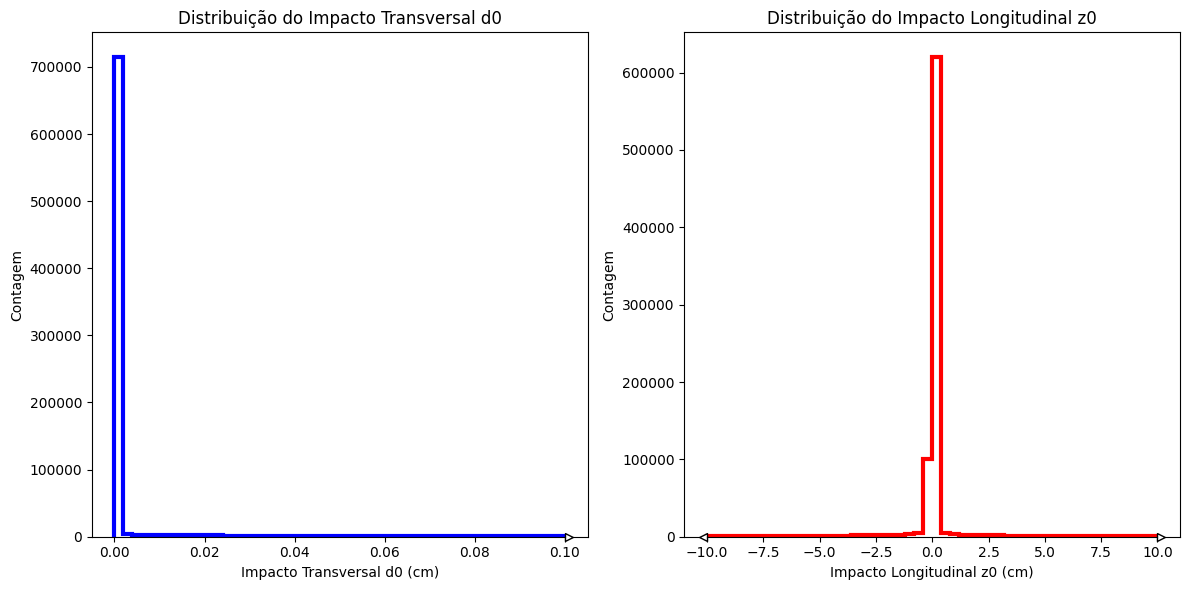

In [4]:

# Histogramas adicionais para parâmetros de impacto
histo_d0 = hist.Hist.new.Reg(50, 0.0, 0.1).Double()  # Impacto transversal (d0)
histo_z0 = hist.Hist.new.Reg(50, -10.0, 10.0).Double()  # Impacto longitudinal (z0)

# Função para calcular o impacto transversal (d0)
def calculate_d0(particle):
    # Obter a posição do vértice de produção
    vertex = particle.production_vertex.position
    x0, y0 = vertex.x, vertex.y  # Coordenadas do vértice
    px, py = particle.momentum.x, particle.momentum.y
    pt = get_pt(particle)
    if pt > 0:
        return abs(x0 * py - y0 * px) / pt  # Fórmula geométrica para d0
    return np.nan

# Função para calcular o impacto longitudinal (z0)
def calculate_z0(particle):
    # Obter a coordenada z do vértice de produção
    return particle.production_vertex.position.z


# Loop para analisar partículas finais com parâmetros de impacto
def analyze_particles_with_impact_params(events):
    for event in events:
        for particle in event.particles:
            if particle.status == 1:  # Apenas partículas finais
                pt = get_pt(particle)
                if pt > 2.0:  # Selecionar partículas com pT > 2 GeV
                    d0 = calculate_d0(particle)
                    z0 = calculate_z0(particle)
                    
                    # Preencher histogramas de parâmetros de impacto
                    histo_d0.fill(d0)
                    histo_z0.fill(z0)

# Função para visualizar os histogramas de parâmetros de impacto
def plot_impact_parameters():
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Histograma do impacto transversal (d0)
    histo_d0.plot(ax=ax[0], ls="-", color="blue", lw=3)
    ax[0].set(xlabel='Impacto Transversal d0 (cm)', ylabel='Contagem')
    ax[0].set_title('Distribuição do Impacto Transversal d0')

    # Histograma do impacto longitudinal (z0)
    histo_z0.plot(ax=ax[1], ls="-", color="red", lw=3)
    ax[1].set(xlabel='Impacto Longitudinal z0 (cm)', ylabel='Contagem')
    ax[1].set_title('Distribuição do Impacto Longitudinal z0')

    plt.tight_layout()
    plt.show()

# Após a análise de jatos, analisar as partículas finais com parâmetros de impacto
analyze_particles_with_impact_params(events)

# Plotar os histogramas de parâmetros de impacto
plot_impact_parameters()
